## Marker gene calculation

In this notebook we calculate marker genes for the cell types of the HLCA. We will first calculate the marker genes of our "grouped" annotations, i.e. a slightly coarser version of our final manual annotations. These coarser annotations are used for the mapping of GWAS results to cell types (for which we'll need the marker genes calculated below), and for the modeling of effects of age, sex etc. on HLCA cell types.  
We will also calculate marker genes for the final, finest cell type annotations. For this we will use a more complex approach, as you will see below.

### Import modules and set paths:

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os

For pretty code formatting (not necessary to run):

In [2]:
%load_ext lab_black

Figure parameters:

In [3]:
sc.set_figure_params(figsize=(5, 5))

Paths:

In [4]:
path_HLCA = "../../data/HLCA_core_h5ads/HLCA_v1.h5ad"
path_man_anns_levd_and_colors = "../../supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv"
dir_DEA_results_coarse_cts = "../../results/DEAs/grouped_manann_vs_rest/"
dir_gene_sets_for_LDSC = "../../results/LDSC/custom_annot_1000genes/genesets/"  # directory where we will store the top 1000 genes for every cell type, will be used for LDSC GWAS analysis
dir_DEA_results_fine_versus_subref = "../../results/DEAs/manann_1_vs_subref_filt/"
dir_DEA_results_fine_versus_comp = "../../results/DEAs/manann_1_vs_comp/"
path_marker_genes = "../../results/DEAs/manann_top10markergenes.csv"

import atlas:

In [5]:
adata = sc.read(path_HLCA)

## DEA for coarse cell types (for LDSC GWAS analysis).

perform differential expression analysis, one-versus-all:

In [ ]:
sc.tl.rank_genes_groups(
    adata, groupby="manual_ann_grouped", use_raw=False, method="t-test"
)

generate a dictionary that maps our gene names to ensembl ids:

In [ ]:
gene_name_to_ens_id = dict(zip(adata.var.index, adata.var.gene_ids))

write dea results, and write top 1000 genes per cell type for LDSC GWAS stratification later. Use ensembl ids rather than gene names.

In [ ]:
for ct in adata.obs.manual_ann_grouped.unique():
    # extract dea dataframe and store to csv
    dea_df = sc.get.rank_genes_groups_df(adata, group=ct)
    # add ensembl ids
    dea_df["gene_ids"] = dea_df.names.map(gene_name_to_ens_id)
    # remove spaces from cell type name
    ct_no_spaces = ct.replace(" ", "_")
    #     write to csv
    dea_df.to_csv(os.path.join(dir_DEA_results_coarse_cts, f"{ct_no_spaces}_vs_rest.csv"))
    with open(
        os.path.join(dir_gene_sets_for_LDSC, f"{ct_no_spaces}.GeneSet"),
        "w+",
    ) as f:
        # exclude HLA genes, since they have funny LD patterns
        dea_df_filt = dea_df.loc[~dea_df.names.str.startswith("HLA-"), :]
        dea_df_final = dea_df_filt.sort_values(by="scores", ascending=False).iloc[
            :1000
        ]
        # make sure these do not include genes with negative t statistics
        if (dea_df_final.scores < 0).any():
            raise ValueError(
                "Note that the top1000 of your DEA are partly lower-expressed genes! Exiting."
            )
        for ens_id in dea_df_final["gene_ids"].values:
            f.write(ens_id + "\n")

also store all genes to file, for LDSC control:

In [ ]:
with open(os.path.join(dir_gene_sets_for_LDSC, "control.GeneSet"), "w+") as f:
    for gene_name, ens_id in zip(adata.var.index, adata.var.gene_ids):
        # exclude HLA genes
        if not gene_name.startswith("HLA-"):
            f.write(ens_id + "\n")

## DEA for marker identification of most detailed cell type annotations. (Compare to rest of compartment, and where needed rest of smaller subref)

We will now calculate top 10 markers for all detailed manual annotations in the HLCA, i.e. the "leaf nodes" of the hierarchical cell-type annotation tree. As we don't want our markers to reflect general differences between coarser cell types (e.g. all epithelial cell types ending up with a general epithelial marker as cell-type specific markers), we only compare to the rest of a cell-type's "compartment" (e.g. other epithelial, immune, endothelial or stromal cells), and take the top 10 after filtering. In some cases, where cell type annotations are very detailed (e.g. macrophage subtypes), we we do an additional comparison between the detailed cell type (e.g. monocyte-derived macrophages) and its parent cell type (all other macrophages). We will then take the top 5 of both comparisons.

load mapper of final anns to leveled anns, if not available anymore from rest of script:

In [6]:
final_anns_to_leveled_anns_df = pd.read_csv(path_man_anns_levd_and_colors, index_col=0)

store cts in bio-based order:

In [7]:
cts = final_anns_to_leveled_anns_df.index.tolist()

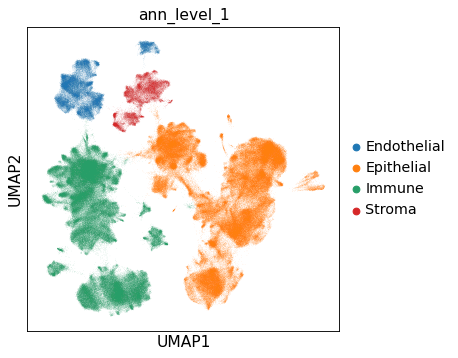

In [8]:
sc.pl.umap(adata, color="ann_level_1")

set wanted filtering type, choose from "default", "strict", "extra strict". We used "strict" for the HLCA paper.

In [9]:
filtering = "strict"

specify for which cell types we also want to compare to a smaller set of cells than the entire compartment. If we don't want to do an additional comparison, set the cell type to "None". 

In [10]:
subreference = {
    "Basal resting": "3_Basal",
    "Suprabasal": "3_Basal",
    "Deuterosomal": "3_Multiciliated lineage",
    "Multiciliated (nasal)": "3_Multiciliated lineage",
    "Multiciliated (non-nasal)": "3_Multiciliated lineage",
    "Club (non-nasal)": "3_Secretory",
    "Club (nasal)": "3_Secretory",
    "Goblet (nasal)": "3_Secretory",
    "Goblet (bronchial)": "3_Secretory",
    "Goblet (subsegmental)": "3_Secretory",
    "Transitional Club-AT2": "3_Secretory",
    "Ionocyte": "None",
    "Tuft": "None",
    "Neuroendocrine": "None",
    "SMG serous (nasal)": "3_Submucosal Secretory",
    "SMG serous (bronchial)": "3_Submucosal Secretory",
    "SMG mucous": "3_Submucosal Secretory",
    "SMG duct": "3_Submucosal Secretory",
    "AT1": "2_Alveolar epithelium",
    "AT2": "2_Alveolar epithelium",
    "AT2 proliferating": "2_Alveolar epithelium",
    "EC arterial": "None",
    "EC aerocyte capillary": "None",
    "EC general capillary": "None",
    "EC venous systemic": "None",
    "EC venous pulmonary": "None",
    "Lymphatic EC mature": "None",
    "Lymphatic EC proliferating": "None",
    "Lymphatic EC differentiating": "None",
    "Peribronchial fibroblasts": "None",
    "Adventitial fibroblasts": "2_Fibroblast lineage",
    "Alveolar fibroblasts": "2_Fibroblast lineage",
    "Pericytes": "2_Fibroblast lineage",
    "Subpleural fibroblasts": "2_Fibroblast lineage",
    "Myofibroblasts": "2_Fibroblast lineage",
    "Smooth muscle": "2_Smooth muscle",
    "Fibromyocytes": "2_Smooth muscle",
    "SM activated stress response": "2_Smooth muscle",
    "Mesothelium": "None",
    "B cells": "None",
    "Plasma cells": "None",
    "CD4 T cells": "3_T cell lineage",
    "CD8 T cells": "3_T cell lineage",
    "T cells proliferating": "3_T cell lineage",
    "NK cells": "None",
    "DC1": "3_Dendritic cells",
    "DC2": "3_Dendritic cells",
    "Migratory DCs": "3_Dendritic cells",
    "Plasmacytoid DCs": "3_Dendritic cells",
    "Alveolar macrophages": "None",
    "Alveolar Mφ CCL3+": "4_Alveolar macrophages",
    "Alveolar Mφ MT-positive": "4_Alveolar macrophages",
    "Alveolar Mφ proliferating": "4_Alveolar macrophages",
    "Monocyte-derived Mφ": "4_Interstitial macrophages",
    "Interstitial Mφ perivascular": "4_Interstitial macrophages",
    "Classical monocytes": "3_Monocytes",
    "Non-classical monocytes": "3_Monocytes",
    "Mast cells": "None",
}

Now perform the DEAs comparing cell types to their smaller-than-compartment sister cell types, and write to file:

In [90]:
subreference_adatas = dict()
for subref in set(subreference.values()):
    if subref != "None":
        print(subref)
        lev = subref[0]
        reflabel = subref[2:]
        subref_adata = adata[
            adata.obs[f"ann_level_{lev}"] == reflabel, :
        ].copy()
        # remove genes without counts:
        sc.pp.filter_genes(subref_adata, min_cells=3)
        # identify level at which sub-annotations are:
        labels_in_subref = [ct for ct in cts if subreference[ct] == subref]
        label_levels = dict()
        for label in labels_in_subref:
            label_levs = [
                labellev
                for labellev in range(1, 6)
                if label in final_anns_to_leveled_anns_df[f"Level_{labellev}"].values
            ]
            if len(label_levs) > 1:
                print("WARNING: THIS LABEL IS PRESENT IN MULTIPLE LEVELS:", label)
            if len(set(subref_adata.obs[f"ann_level_{label_levs[0]}"])) == 1:
                print(
                    f"Subref {subref} has only one label at level {label_levs[0]}. Ignoring this annotation level, and setting level one higher."
                )
                subref_adata.obs[f"ann_level_{label_levs[0] + 1}"] = subref_adata.obs[
                    f"ann_level_{label_levs[0] + 1}"
                ].tolist()
                subref_adata.obs.loc[
                    subref_adata.obs.manual_ann == label,
                    f"ann_level_{label_levs[0] + 1}",
                ] = label
                label_levs[0] = label_levs[0] + 1

            label_levels[label] = label_levs[0]
        # now perform DEA at all wanted levels and filter according to filtering setting.
        for dea_level in set(label_levels.values()):
            print(dea_level)
            sc.tl.rank_genes_groups(
                subref_adata,
                groupby=f"ann_level_{dea_level}",
                use_raw=False,
                method="t-test",
                key_added=f"ann_level_{dea_level}",
            )
            if filtering == "default":
                sc.tl.filter_rank_genes_groups(
                    subref_adata, key=f"ann_level_{dea_level}"
                )
            elif filtering == "strict":
                sc.tl.filter_rank_genes_groups(
                    subref_adata,
                    key=f"ann_level_{dea_level}",
                    min_in_group_fraction=0.5,
                    max_out_group_fraction=0.25,
                )
            elif filtering == "extra_strict":
                sc.tl.filter_rank_genes_groups(
                    subref_adata,
                    key=f"ann_level_{dea_level}",
                    min_in_group_fraction=0.3,
                    max_out_group_fraction=0.02,
                )
        for ct in labels_in_subref:
            if ct in label_levels.keys():
                labellev = label_levels[ct]
            else:
                ct_matched = [ct_new for ct_new in label_levels.keys() if ct in ct_new][
                    0
                ]
                print(f"WARNING: assuming that {ct_matched} is the same as {ct}.")
                ct = ct_matched
                labellev = label_levels[ct_matched]
            ct_no_spaces = ct.replace(" ", "_")
            dea_df_filtered = sc.get.rank_genes_groups_df(
                subref_adata, group=ct, key=f"ann_level_{labellev}"
            )
            if filtering == "default":
                dea_df_filtered.to_csv(
                    os.path.join(dir_DEA_results_fine_versus_subref, f"{ct_no_spaces}_dea_results_ttest_filt.csv")
                )
            elif filtering == "strict":
                dea_df_filtered.to_csv(
                    os.path.join(dir_DEA_results_fine_versus_subref, f"{ct_no_spaces}_dea_results_ttest_filt_strict.csv")
                )
            elif filtering == "extra_strict":
                dea_df_filtered.to_csv(
                    os.path.join(dir_DEA_results_fine_versus_subref, f"{ct_no_spaces}_dea_results_ttest_filt_extra_strict.csv")
                )

2_Smooth muscle


... storing 'ann_level_3' as categorical


Subref 2_Smooth muscle has only one label at level 2. Ignoring this annotation level, and setting level one higher.
3
3_Monocytes
4
3_Dendritic cells
4
3_Multiciliated lineage
4
5


Now do the cell-type versus compartment DEA (i.e. one versus Epithelial/Endothelial/Immune/Stromal), for all final annotations, and write to file:

In [15]:
subadatas = dict()
for comp in adata.obs.ann_level_1.unique():
    print(comp)
    if comp != "Immune":  # temporary, since I already ran immune in a previous run
        subadata = adata[adata.obs.ann_level_1 == comp, :].copy()
        print(subadata.shape)
        sc.tl.rank_genes_groups(
            subadata, groupby="manual_ann", use_raw=False, method="t-test"
        )
        if filtering == "default":
            sc.tl.filter_rank_genes_groups(subadata)
        elif filtering == "strict":
            sc.tl.filter_rank_genes_groups(
                subadata, min_in_group_fraction=0.5, max_out_group_fraction=0.25
            )
        elif filtering == "extra_strict":
            sc.tl.filter_rank_genes_groups(
                subadata, min_in_group_fraction=0.3, max_out_group_fraction=0.02
            )
        else:
            raise ValueError("FILTERING SHOULD BE SET TO EITHER 'STRICT' OR 'DEFAULT'!")
        for ct in subadata.obs.manual_ann.unique():
            print(ct)
            ct_no_spaces = ct.replace(" ", "_")
            dea_df_filtered = sc.get.rank_genes_groups_df(
                subadata, group=ct, key="rank_genes_groups_filtered"
            )  # .dropna(axis=0)
            if filtering == "default":
                dea_df_filtered.to_csv(
                     os.path.join(dir_DEA_results_fine_versus_comp, f"{ct_no_spaces}_dea_results_ttest_filt.csv")
                )
            elif filtering == "strict":
                dea_df_filtered.to_csv(
                    os.path.join(dir_DEA_results_fine_versus_comp, f"{ct_no_spaces}_dea_results_ttest_filt_strict.csv")
                )
            elif filtering == "extra_strict":
                dea_df_filtered.to_csv(
                     os.path.join(dir_DEA_results_fine_versus_comp, f"{ct_no_spaces}_dea_results_ttest_filt_extra_strict.csv")
                )

            dea_df = sc.get.rank_genes_groups_df(
                subadata, group=ct, key="rank_genes_groups"
            )
            dea_df.to_csv(
                os.path.join(dir_DEA_results_fine_versus_comp, f"{ct_no_spaces}_dea_results_ttest_unfilt.csv")
            )
        subadatas[comp] = subadata

Generate the final marker table, with max. 10 markers per cell type (and fewer only if no more genes passed filtering):

In [11]:
n_genes_per_ct = 10

In [14]:
verbose = False
# initiate empty dataframe
marker_genes = pd.DataFrame(index=np.arange(n_genes_per_ct), columns=cts)
# initiate empty dictionary in which to track number of markers per ct
n_marker_genes_per_ct = dict()
for ct in cts:
    ct_no_spaces = ct.replace(" ", "_")
    # import one versus compartment results (stored above)
    dea_df_comp = pd.read_csv(
        os.path.join(
            dir_DEA_results_fine_versus_comp,
            f"{ct_no_spaces}_dea_results_ttest_filt_strict.csv",
        )
    ).dropna(axis=0)
    # check if a one-versus-"subreference" exists. If so, import those results too
    subref_path = os.path.join(
        dir_DEA_results_fine_versus_subref,
        f"{ct_no_spaces}_dea_results_ttest_filt_strict.csv",
    )
    if os.path.isfile(subref_path):
        dea_df_subref = pd.read_csv(subref_path).dropna(axis=0)
        has_subref = True
        comp_marker_n = int(n_genes_per_ct / 2)
        if verbose:
            print(f"{ct} has a subreference.")
    else:
        if verbose:
            print(f"{ct} has no subreference.")
        comp_marker_n = n_genes_per_ct
        n_marker_genes_subref = 0
        marker_genes_subref = []
        has_subref = False
    n_marker_genes_comp = min(dea_df_comp.shape[0], comp_marker_n)
    marker_genes_comp = (
        dea_df_comp.sort_values(by="scores", ascending=False)
        .iloc[:n_marker_genes_comp, :]
        .names.values.tolist()
    )
    if has_subref:
        # remove marker genes selected based on compartment dea from df:
        dea_df_subref = dea_df_subref.loc[
            ~dea_df_subref.names.isin(marker_genes_comp), :
        ]
        dea_df_subref = dea_df_subref.loc[
            dea_df_subref.names.isin(dea_df_comp.names), :
        ]
        # count how many genes we can select
        n_marker_genes_subref = min(
            dea_df_subref.shape[0], n_genes_per_ct - comp_marker_n
        )
        if verbose:
            print("n marker genes subref:", n_marker_genes_subref)
        # extract top marker genes
        marker_genes_subref = (
            dea_df_subref.sort_values(by="scores", ascending=False)
            .iloc[:n_marker_genes_subref, :]
            .names.values.tolist()
        )
        if verbose:
            print(
                "Comp degs and subref degs unique?",
                len(marker_genes_subref + marker_genes_comp)
                == len(set(marker_genes_subref + marker_genes_comp)),
            )
    marker_genes_ct = marker_genes_comp + marker_genes_subref

    n_marker_genes_per_ct[ct] = n_marker_genes_comp + n_marker_genes_subref
    marker_genes.iloc[: n_marker_genes_per_ct[ct], :][ct] = marker_genes_ct

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
marker_genes

,Basal resting,Suprabasal,Deuterosomal,Multiciliated (nasal),Multiciliated (non-nasal),Club (non-nasal),Club (nasal),Goblet (nasal),Goblet (bronchial),Goblet (subsegmental),...,Plasmacytoid DCs,Alveolar macrophages,Alveolar Mφ CCL3+,Alveolar Mφ MT-positive,Alveolar Mφ proliferating,Monocyte-derived Mφ,Interstitial Mφ perivascular,Classical monocytes,Non-classical monocytes,Mast cells
0,KRT15,KRT5,CCNO,C20orf85,C20orf85,TSPAN8,ASRGL1,LYPD2,MUC5B,TSPAN8,...,GZMB,FABP4,MIR3945HG,MT1X,KIAA0101,RNASE1,F13A1,FCN1,FCN1,TPSAB1
1,KRT17,KRT17,CDC20B,C9orf24,CAPS,CYP2F1,LYPD2,PI3,RARRES1,MUC5B,...,JCHAIN,APOE,CCL20,MT1E,CKS1B,C15orf48,RNASE1,VCAN,LILRB2,TPSB2
2,KRT5,SERPINB4,ZMYND10,RSPH1,C9orf24,TFF3,UGT2A1,CEACAM5,SAA1,C16orf89,...,ITM2C,MSR1,HLA-DQA2,MT1G,TYMS,VCAN,STAB1,S100A12,FGL2,CPA3
3,DST,SERPINB13,KIF9,PIFO,RSPH1,TGM2,TFCP2L1,LYNX1,ANKRD36C,MTRNR2L10,...,IRF7,SERPING1,PHLDA3,SFTPB,CENPW,CXCL8,RNASE6,CFP,CFP,HPGDS
4,DLK2,KRT6A,FOXJ1,RP11-356K23.1,FAM183A,MUC5B,LY6D,MUC5AC,SAA2,CLCA2,...,PPP1R14B,MCEMP1,ITGB8,KCNMA1,NUSAP1,NaN,GPR183,EREG,LILRA5,MS4A2
5,IL33,CLCA2,HES6,CCDC80,MS4A8,CXCL6,TPD52L1,MUC16,LYZ,CFD,...,C12orf75,TREM1,CCL4L2,EMP1,CDK1,NaN,FGL2,CD300E,CSF1R,GATA2
6,FHL2,LY6D,CEP78,PROM1,TFF3,C16orf89,SORD,C15orf48,PLCG2,KIAA1324,...,TSPAN13,GPNMB,NINJ1,MT1F,UBE2C,NaN,CSF1R,FGL2,LILRB1,KIT
7,PTPRZ1,PPP1R14B,TMEM106C,OMG,IGFBP5,HES4,PI3,BPIFA1,FCGBP,LTF,...,UGCG,CYP27A1,SCGB3A1,C15orf48,PTTG1,NaN,FCGR2B,NaN,WARS,CLU
8,NaN,AKR1C3,CCDC67,DIAPH2,CFAP43,RHOV,NaN,CCDC80,RIMS1,TMEM45A,...,APP,PPARG,TNIP3,RP11-598F7.3,MKI67,NaN,IL13RA1,NaN,FAM26F,VWA5A
9,NaN,IGFBP3,KDELC2,C15orf48,C2orf40,KIAA1324,NaN,DHRS9,MUC5AC,FCGBP,...,TCF4,NUPR1,CXCL5,NaN,SMC4,NaN,METRNL,NaN,LIMD2,RGS13


write to file:

In [ ]:
marker_genes.to_csv(path_marker_genes)